# Geofences for dockless shared vehicles
This notebook documents work around creating a listing of polygons within which scooters are required to behave differently, namely disable parking or disuade riding.

## Parks
The first area that we want to look at are parks.  We'll use Portland's Open Data Portal to get the official geometries of parks in Portland

In [157]:
import geopandas as gpd
pdx_parks = gpd.read_file('https://opendata.arcgis.com/datasets/9eef54196eaa4d12b54e9bc40e70ff09_35.geojson')
pdx_parks = pdx_parks[['NAME', 'geometry']].rename(index=str, columns={'NAME': 'name'})

## PSU parking structures
Next, we'll add in some PSU structures that PSU requested no parking in.

In [161]:
import overpy
api = overpy.Overpass()
result = api.query("""
(
    way
    ["amenity"="parking"]
    ["parking"="multi-storey"]
    ["operator"="Portland State University"]
    (45.378437479737,-122.7921295166,45.627484212338,-122.42992401123);
    way(354681069);
);
(
    ._;
    >;
);
out;
""")
len(result.ways)

4

We'll need a function to trransform ways into polygons so we can make a GeoDataFrame from them

In [171]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.linestring import LineString
def create_polygon(way):
    coordinates=[]
    for n in way.nodes:
        node = next(x for x in result.nodes if x.id == n.id)
        coordinates.append((node.lon, node.lat))
    return Polygon(coordinates)

def create_line(way):
    coordinates=[]
    for n in way.nodes:
        node = next(x for x in result.nodes if x.id == n.id)
        coordinates.append((node.lon, node.lat))
    return LineString(coordinates)

Then we'll transform the ways we retrieved from Overpass into a GeoDataFrame

In [163]:
items = []
for way in result.ways:
    polygon = create_polygon(way)
    item = way.tags
    item['geometry'] = polygon
    items.append(item)
parking_structures = gpd.GeoDataFrame(items)    

In [164]:
parking_structures = parking_structures[['name', 'geometry']]
parking_structures.head()

,name,geometry
0,Parking Structure 1,"POLYGON ((-122.6831199 45.511041, -122.6833536..."
1,Parking Structure 3,"POLYGON ((-122.6888138 45.5136524, -122.688841..."
2,Parking Structure 2,"POLYGON ((-122.6832114 45.5124287, -122.683258..."
3,Green Zebra,"POLYGON ((-122.6829319 45.5125178, -122.683074..."


## Smart Park Garages
We were also requested to add Smart Park garages to the list of no parking zones so let's see how we can find those

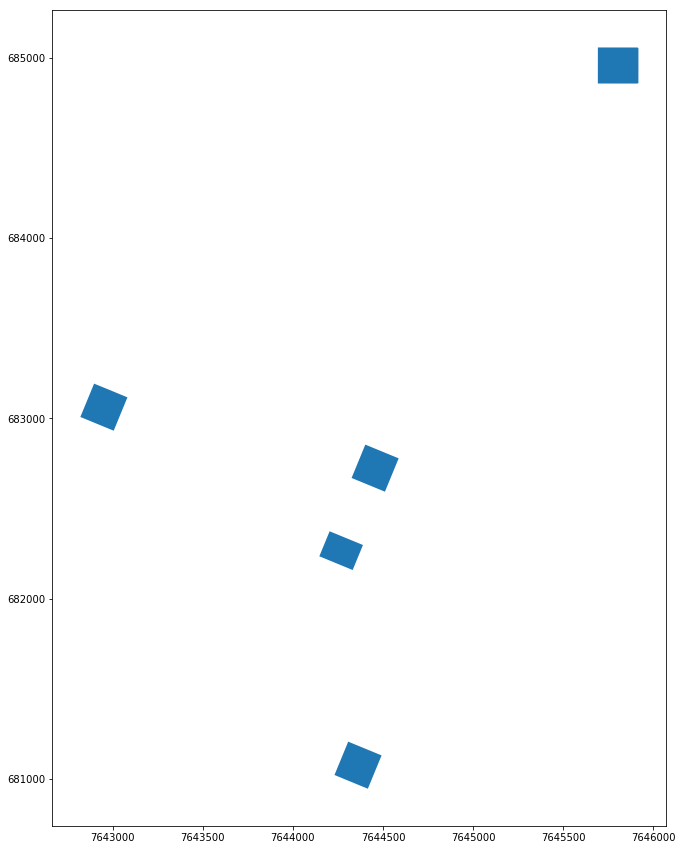

In [236]:
smart_park = gpd.read_file("../.data/NoParking_SmartParkGarages/SmartParkGarages.shp")
smart_park.plot(figsize=(15,15))

In [241]:
smart_park = smart_park.to_crs(epsg=4326)[['geometry']]
smart_park['name'] = 'Smart Park Garage'
smart_park.head()

,geometry,name
0,POLYGON ((-122.6704410470196 45.52522931952632...,Smart Park Garage
1,POLYGON ((-122.6819966682766 45.51989388236046...,Smart Park Garage
2,POLYGON ((-122.6762894334122 45.51455231804633...,Smart Park Garage
3,POLYGON ((-122.6760923882594 45.51907756555509...,Smart Park Garage
4,POLYGON ((-122.6768142277196 45.51774477177767...,Smart Park Garage


## Lloyd Center Mall
Next, we'll add Lloyd Center mall, per their request by using the Overpass API

In [165]:
result = api.query("""
(
    way(451267591);
);
(
    ._;
    >;
);
out;
""")
len(result.ways)

1

In [166]:
items = []
for way in result.ways:
    polygon = create_polygon(way)
    item = way.tags
    item['geometry'] = polygon
    items.append(item)
lloyd_center = gpd.GeoDataFrame(items)

In [168]:
lloyd_center = lloyd_center[['name', 'geometry']]
lloyd_center.head()

,name,geometry
0,Lloyd Center,"POLYGON ((-122.6565047 45.5335493, -122.656492..."


## Bus stops
Finally, we'll add all bus stops via Overpass and place a 30 foot buffer around them to create space for accessing buses

In [215]:
result = api.query("""
(
    node
    ["public_transport"="platform"]
    (45.378437479737,-122.7921295166,45.627484212338,-122.42992401123);
    way
    ["public_transport"="platform"]
    (45.378437479737,-122.7921295166,45.627484212338,-122.42992401123);
);
(
    ._;
    >;
);
out;
""")
len(result.nodes)

3193

In [228]:
items = []
# We'll need to not duplicate adding the point geometries later on
resolved_nodes = []
for way in result.ways:
    if len(way.nodes) > 2:
        polygon = create_polygon(way)
    else:
        polygon = create_line(way)
    nodes = [n.id for n in way.nodes]
    resolved_nodes = resolved_nodes + nodes
    item = way.tags
    item['geometry'] = polygon
    items.append(item)

from shapely.geometry.point import Point
nodes = (n for n in result.nodes if n.id not in resolved_nodes)
for node in nodes:
    point = Point((node.lon, node.lat))
    item = node.tags
    item['geometry'] = point
    items.append(item)

bus_stops = gpd.GeoDataFrame(items)

In [229]:
# Use the cities dataset to limit to stops in the Portland boundaries
cities = gpd.read_file('https://opendata.arcgis.com/datasets/1559e31273654eb9858397861f1fdefa_10.geojson')
cities = cities[cities['CITYNAME'] == 'Portland']
bus_stops = gpd.sjoin(bus_stops, cities)[['name', 'geometry']]
bus_stops.head()

,name,geometry
0,Morrison Bridge,"POLYGON ((-122.6662101 45.516468, -122.6662099..."
1,Parkrose/Sumner Transit Center,"POLYGON ((-122.565859 45.5588036, -122.5656655..."
2,Northeast 60th Avenue,"POLYGON ((-122.6027255 45.5288015, -122.602905..."
3,Hollywood Transit Center/Northeast 42nd Avenue,"LINESTRING (-122.6206678 45.5327864, -122.6210..."
4,Interstate/Rose Quarter,"LINESTRING (-122.6682216 45.5304271, -122.6673..."


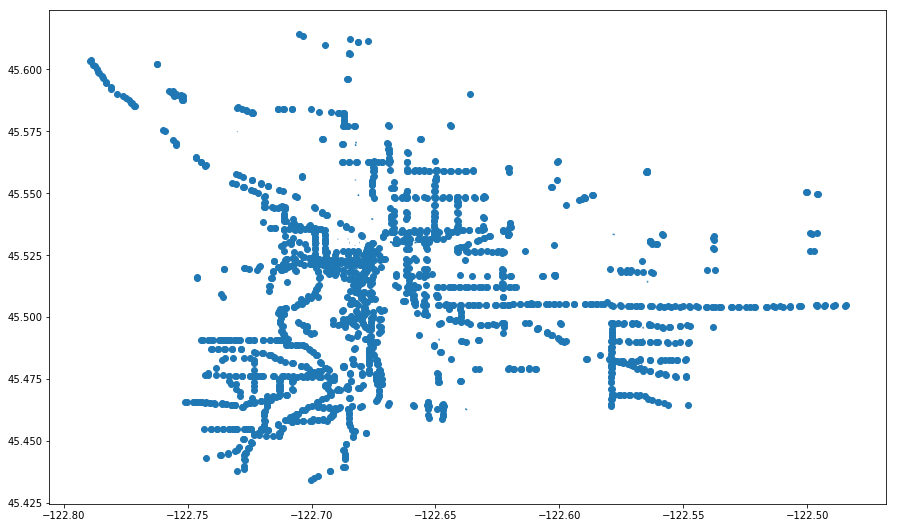

In [230]:
bus_stops.plot(figsize=(15,15))

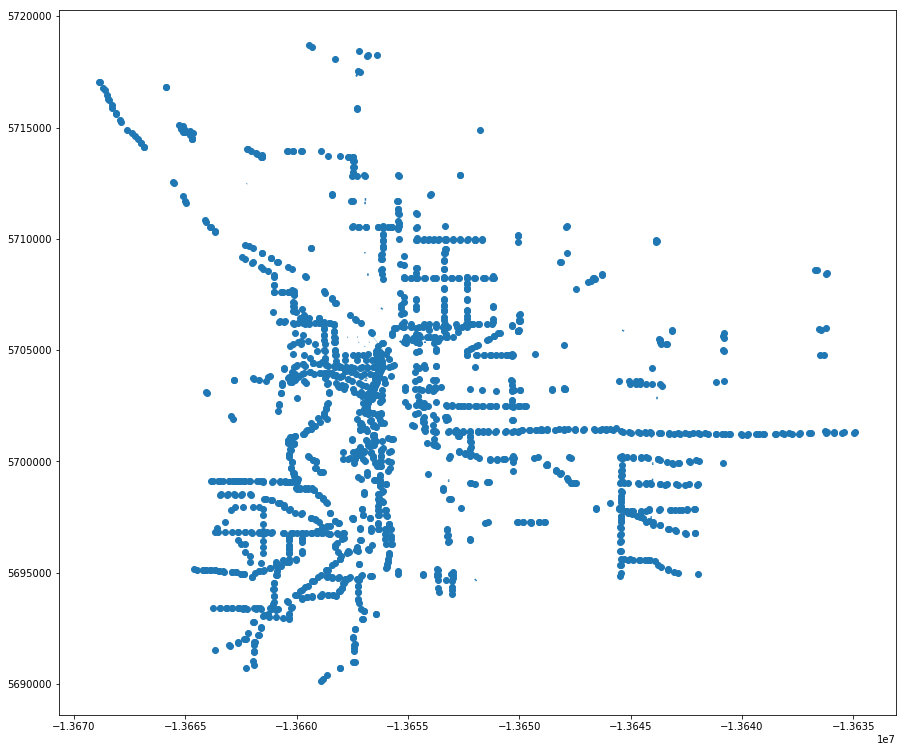

In [231]:
bus_stops.crs = {'init' :'epsg:4326'}
bus_stops = bus_stops.to_crs(epsg=3857)
bus_stops.plot(figsize=(15,15))

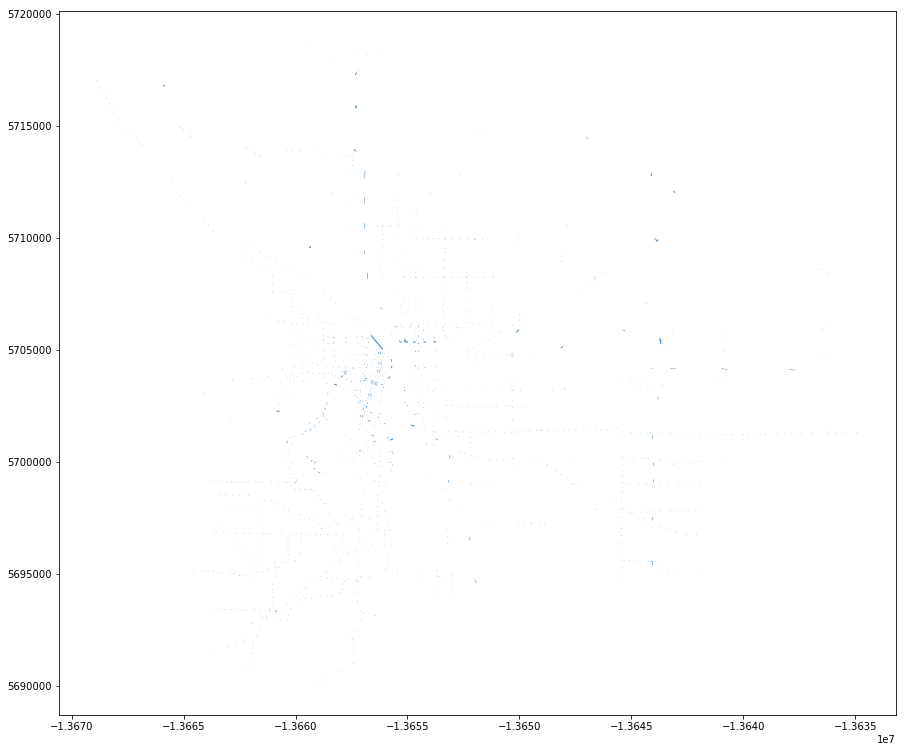

In [232]:
bus_stops['geometry'] = bus_stops['geometry'].buffer(10.0)
bus_stops.plot(figsize=(15,15))

In [233]:
bus_stops = bus_stops.to_crs(epsg=4326)

## Combining everything
Now, we need to combine all the datasets we've created into one no parking zone dataset

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


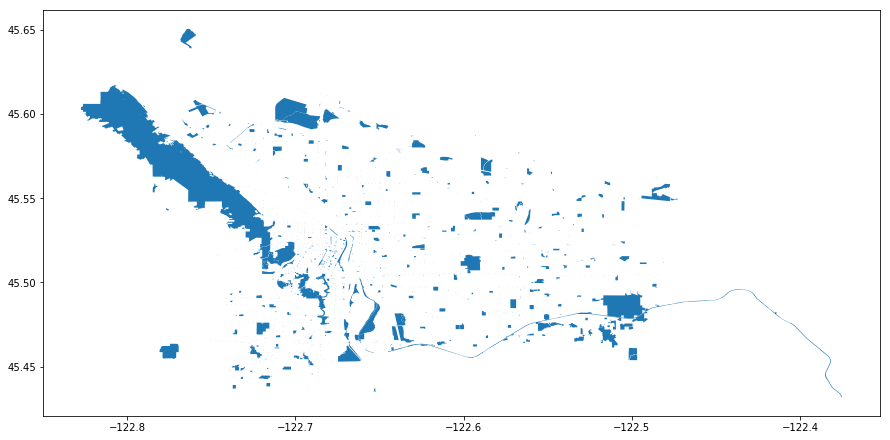

In [242]:
combined_datasets = pd.concat([pdx_parks, parking_structures, lloyd_center, smart_park, bus_stops])
combined_datasets.plot(figsize=(15,15))

Since this is a non-uniform set of geometries, we can't use geopandas' to_file, so we will work around that

In [243]:
with open('../.data/no_parking_zones.geojson', 'w') as f:
    f.write(combined_datasets.to_json())

In [244]:
no_riding = pd.concat([pdx_parks, parking_structures, lloyd_center, smart_park])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [245]:
with open('../.data/no_riding_zones.geojson', 'w') as f:
    f.write(no_riding.to_json())